<a href="https://colab.research.google.com/github/devpathak0212/Chat-app-Minima/blob/master/DeepLearningModels/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing the datasets from kaggle**

In [ ]:
!pip install kaggle --upgrade

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nabilsherif/oil-spill

Dataset URL: https://www.kaggle.com/datasets/nabilsherif/oil-spill
License(s): unknown


In [ ]:
!unzip '/content/oil-spill.zip'

Archive:  /content/oil-spill.zip
  inflating: oil-spill/test/images/img_0001.jpg  
  inflating: oil-spill/test/images/img_0002.jpg  
  inflating: oil-spill/test/images/img_0003.jpg  
  inflating: oil-spill/test/images/img_0004.jpg  
  inflating: oil-spill/test/images/img_0005.jpg  
  inflating: oil-spill/test/images/img_0006.jpg  
  inflating: oil-spill/test/images/img_0007.jpg  
  inflating: oil-spill/test/images/img_0008.jpg  
  inflating: oil-spill/test/images/img_0009.jpg  
  inflating: oil-spill/test/images/img_0010.jpg  
  inflating: oil-spill/test/images/img_0011.jpg  
  inflating: oil-spill/test/images/img_0012.jpg  
  inflating: oil-spill/test/images/img_0013.jpg  
  inflating: oil-spill/test/images/img_0014.jpg  
  inflating: oil-spill/test/images/img_0015.jpg  
  inflating: oil-spill/test/images/img_0016.jpg  
  inflating: oil-spill/test/images/img_0017.jpg  
  inflating: oil-spill/test/images/img_0018.jpg  
  inflating: oil-spill/test/images/img_0019.jpg  
  inflating: oil-

# **Importing the Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator


from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support,accuracy_score

from keras.models import Model
from keras import backend as K

# **Constants and file paths**

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CLASSES = 5
IMG_CHANNELS = 3

IMG_PATH = '/content/oil-spill/train/images'
LABELS_PATH = '/content/oil-spill/train/labels'

IMG_PATH_TEST = '/content/oil-spill/test/images'
LABELS_PATH_TEST = '/content/oil-spill/test/labels'

# **List of Images**

In [ ]:
# Get a list of all image filenames in the directory
IMG_IDS = sorted(os.listdir(IMG_PATH))
LABELS_IDS = sorted(os.listdir(LABELS_PATH))

IMG_IDS_TEST = sorted(os.listdir(IMG_PATH_TEST))
LABELS_IDS_TEST = sorted(os.listdir(LABELS_PATH_TEST))

# **Visualize Images**

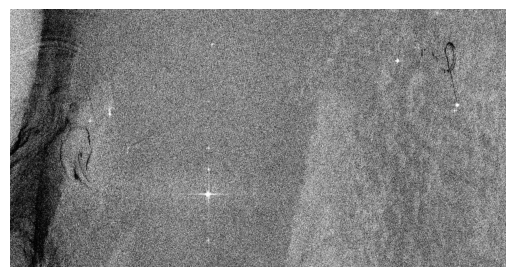

Image:  img_0006.jpg


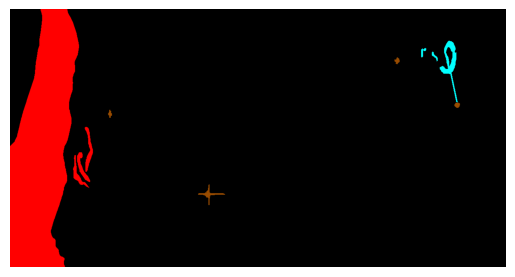

Respective mask:  img_0006.png


In [ ]:
# Choose a random image and mask filename from the list
sample_image = IMG_IDS[5]
sample_mask = LABELS_IDS[5]

# Construct the full image path
image_path = os.path.join(IMG_PATH, sample_image)
mask_path = os.path.join(LABELS_PATH, sample_mask)

# Read and plot the image
img = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

plt.imshow(img)
plt.axis('off')
plt.savefig('img5.png')
plt.show()

print("Image: ", sample_image)

plt.imshow(mask)
plt.axis('off')
plt.savefig('mask5.png')
plt.show()


print("Respective mask: ", sample_mask)

# Color **Mask**

In [ ]:
COLOR_MAP = [
    [0, 0, 0],
    [0, 255, 255],
    [255, 0, 0],
    [153, 76, 0],
    [0, 153, 0],
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [ ]:
train_images = []
train_masks = []

test_images = []
test_masks = []

# **Loading Training Images**

In [ ]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS, LABELS_IDS),total = len(IMG_IDS)):
    image_path = os.path.join(IMG_PATH, image_filename)
    mask_path = os.path.join(LABELS_PATH, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))

    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 1002/1002 [00:30<00:00, 33.39it/s]


# **Loading Testing Images**

In [ ]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS_TEST, LABELS_IDS_TEST),total = len(IMG_IDS_TEST)):
    image_path = os.path.join(IMG_PATH_TEST, image_filename)
    mask_path = os.path.join(LABELS_PATH_TEST, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))

    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

100%|██████████| 110/110 [00:02<00:00, 38.76it/s]


In [ ]:
train_masks.shape

(1002, 256, 256, 1)

In [ ]:
test_masks.shape

(110, 256, 256, 1)

In [ ]:
unique_values = np.unique(train_masks)
print("Unique values in train_masks:", unique_values)

Unique values in train_masks: [0 1 2 3 4]


In [ ]:
unique_values = np.unique(test_masks)
print("Unique values in test_masks:", unique_values)

Unique values in test_masks: [0 1 2 3 4]


# **Displaying few Masked Images**

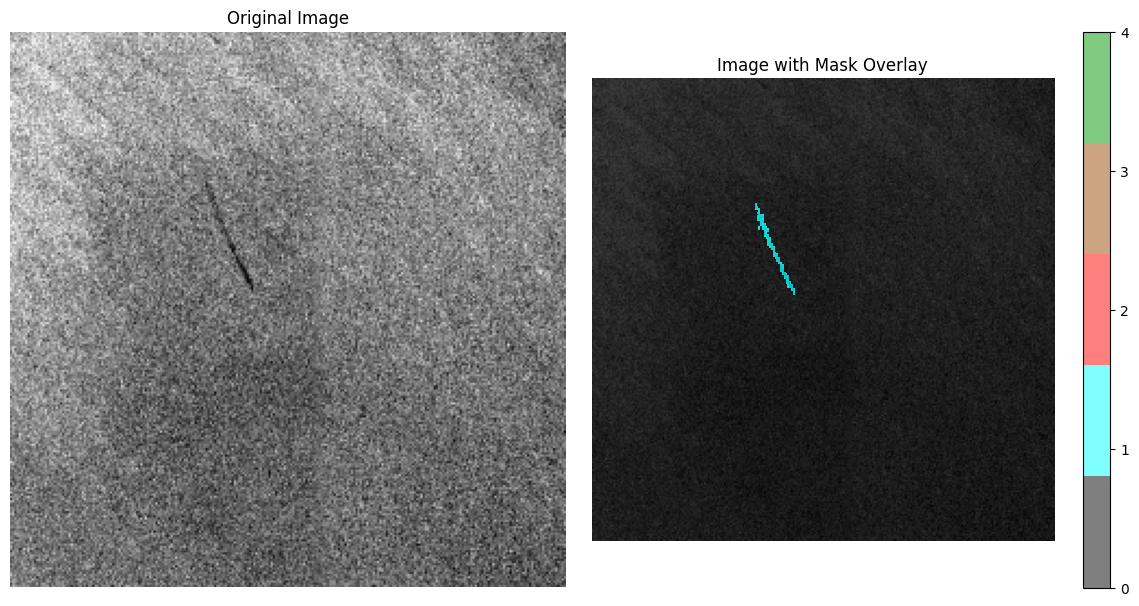

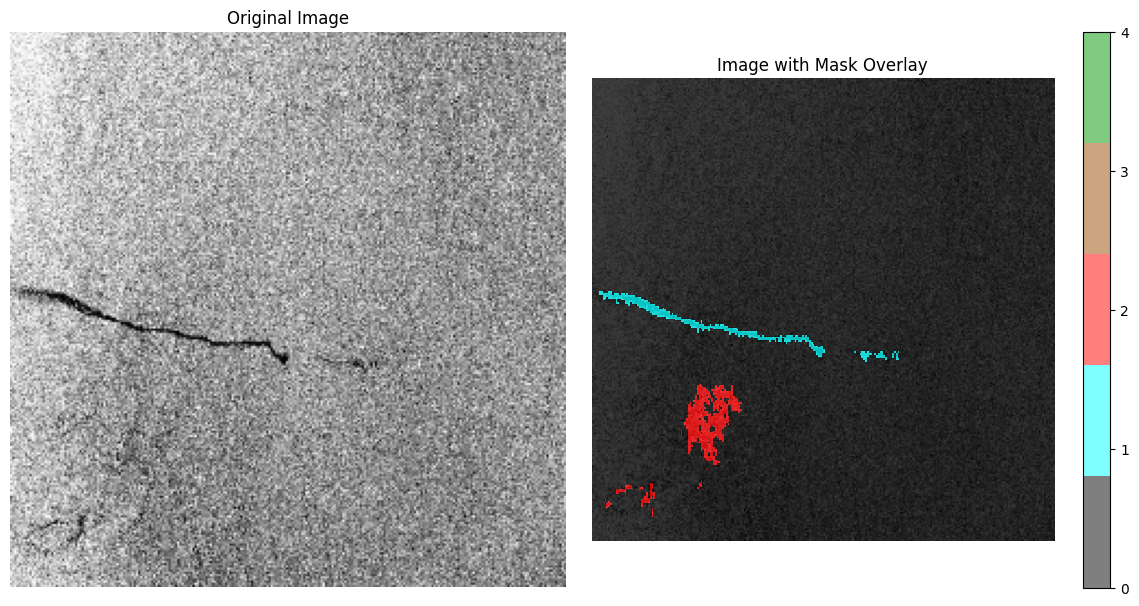

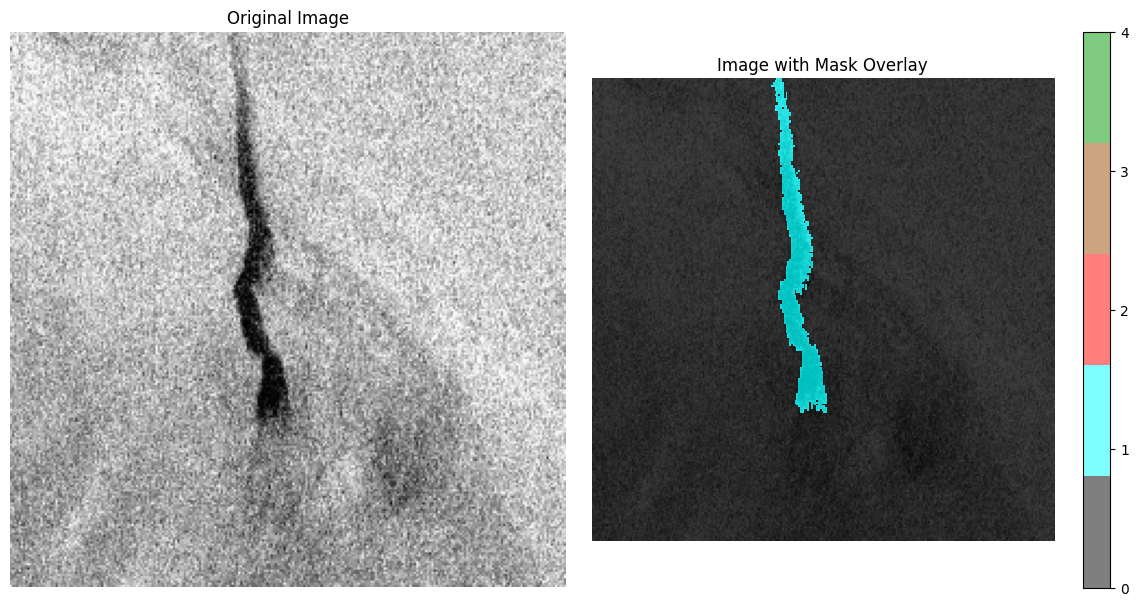

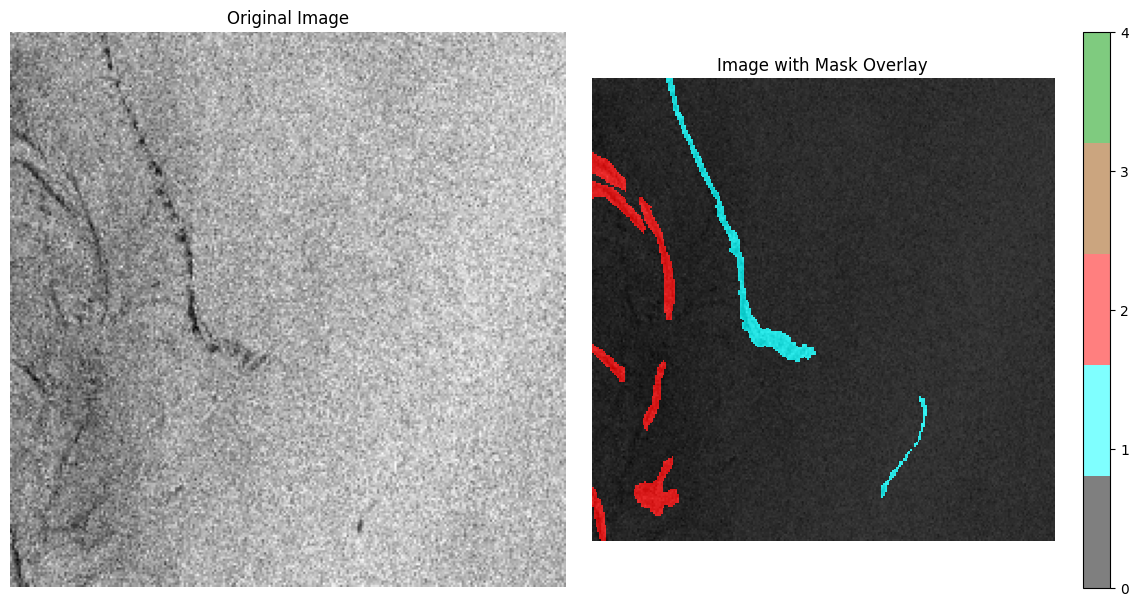

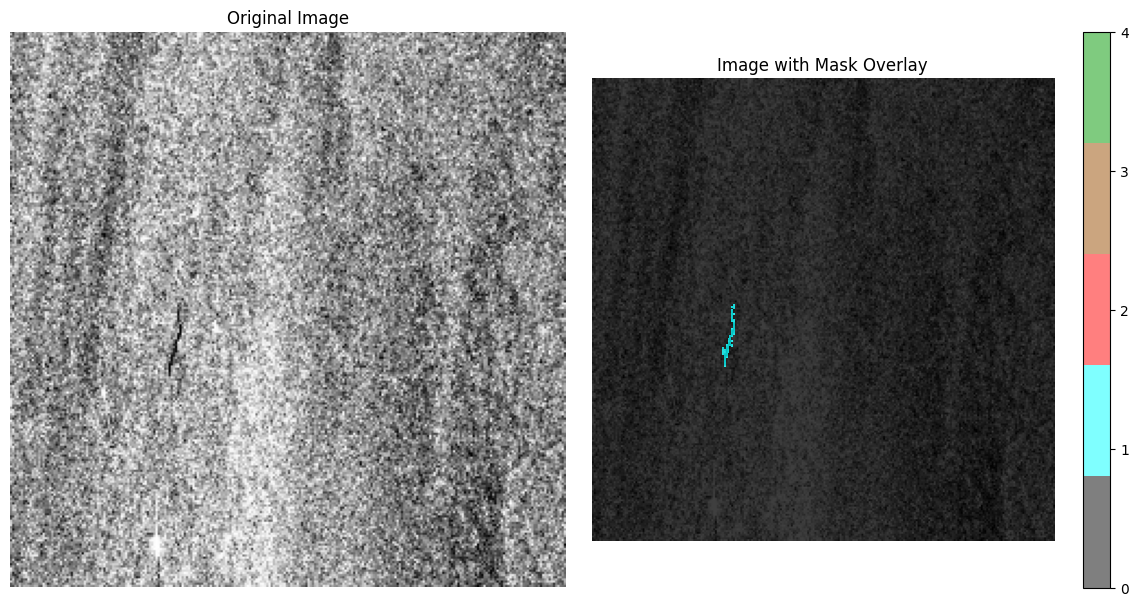

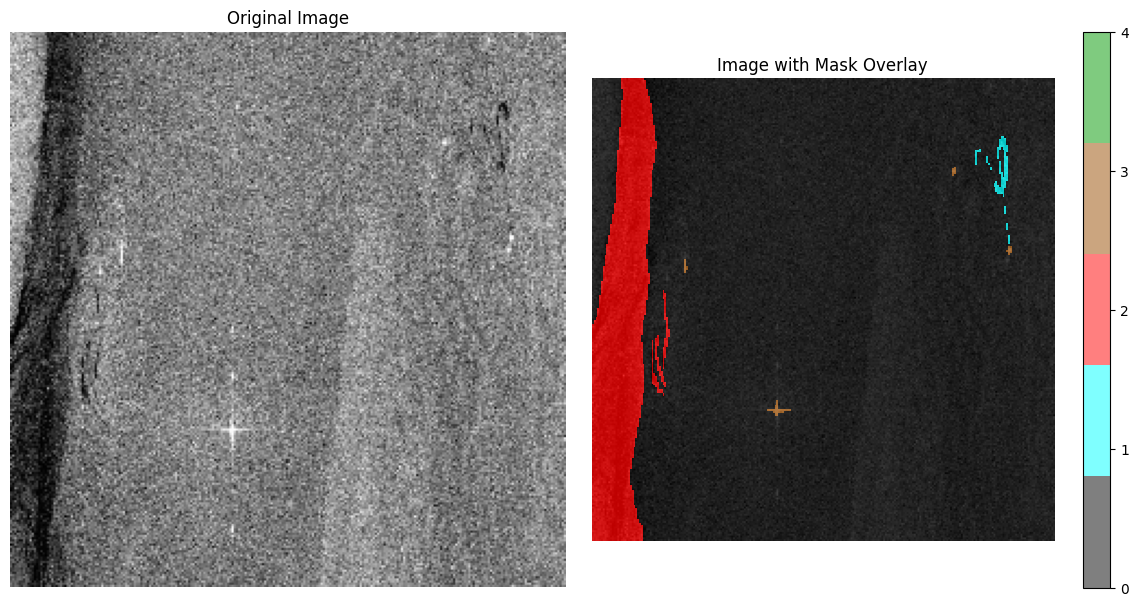

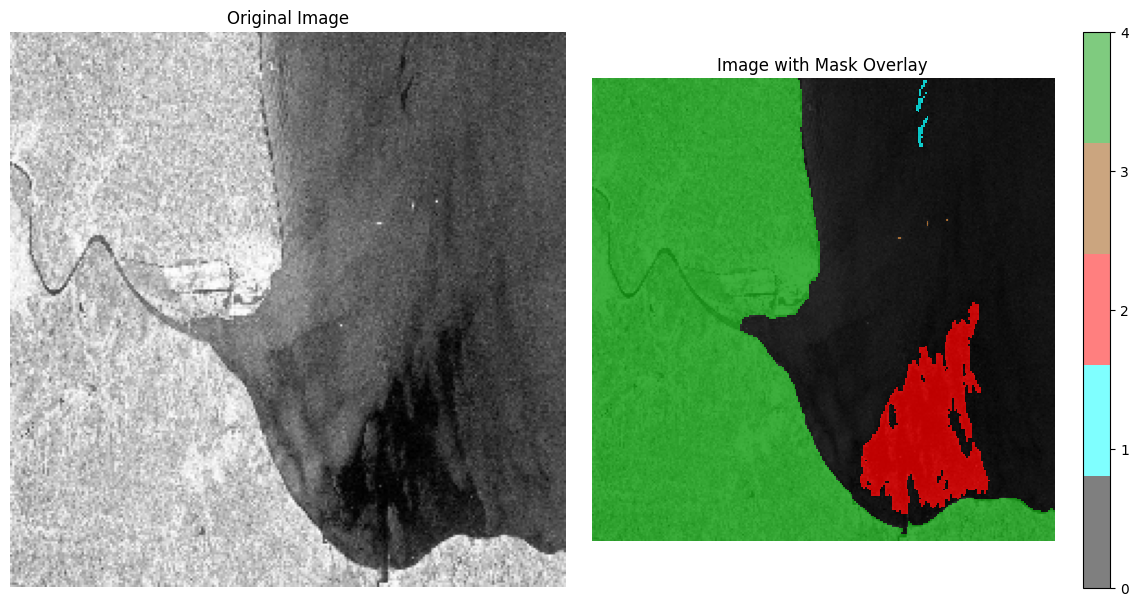

In [ ]:
# Assuming COLOR_MAP and train_images, train_masks are defined as in the original notebook
scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]
cmap = mcolors.ListedColormap(scaled_color_map)
num_images_to_plot = 7

for i in range(num_images_to_plot):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns of subplots

    # Display the original image on the left subplot
    axes[0].imshow(train_images[i])
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the image with mask overlay on the right subplot
    mask_overlay = train_masks[i].squeeze()
    axes[1].imshow(train_images[i])  # Display the original image again as the base
    axes[1].imshow(mask_overlay, cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, alpha=0.5, interpolation='none')  # Overlay mask with transparency
    axes[1].set_title("Image with Mask Overlay")
    axes[1].axis('off')

    plt.colorbar(axes[1].imshow(mask_overlay, cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, alpha=0.5, interpolation='none'), ax = axes[1] ,ticks=range(len(COLOR_MAP))) # Add a colorbar to the overlay plot

    plt.tight_layout() # adjust subplot parameters to give specified padding
    plt.show()

In [ ]:
train_masks = to_categorical(train_masks, num_classes = 5)
test_masks = to_categorical(test_masks, num_classes = 5)

In [ ]:
print(train_images.shape)
print(train_masks.shape)

(1002, 256, 256, 3)
(1002, 256, 256, 5)


In [ ]:
print(test_images.shape)
print(test_masks.shape)

(110, 256, 256, 3)
(110, 256, 256, 5)


In [ ]:
print(np.unique(train_masks))
print(np.unique(test_masks))

[0. 1.]
[0. 1.]


In [ ]:
# atrous_spatial_pyramid_pooling
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [ ]:
def DeepLabV3Plus(input_shape, IMG_CLASSES):
    # Inputs
    inputs = layers.Input(input_shape)

    # Pre-trained ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Pre-trained ResNet50 Output
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    # Get low-level features
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    # Outputs
    x = Conv2D(IMG_CLASSES, (1, 1), name='output_layer')(x)
    x = Activation('softmax')(x)

    # Model
    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
deeplab_model = DeepLabV3Plus(input_shape, IMG_CLASSES)
deeplab_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 17,831,237 (68.02 MB)

 Trainable params: 17,796,453 (67.89 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [ ]:
import tensorflow.keras.backend as K  # Import the correct backend

def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)  # Use K.flatten from the correct backend
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [ ]:
# treating all classes equally in terms of their contribution to the loss.
class_weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [ ]:
!pip install -U -q segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

dice_loss = sm.losses.DiceLoss(class_weights = class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + focal_loss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [ ]:
data_gen_args = dict(
    rotation_range=20,  # Rotate images by up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
    shear_range=0.2,  # Apply shear transformations
    zoom_range=0.2,  # Zoom in or out by up to 20%
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels using the nearest neighbor method
)

In [ ]:
# Create image data generators
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [ ]:
def train_generator_fn(image_datagen, mask_datagen, train_images, train_masks, batch_size):
    image_generator = image_datagen.flow(train_images, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(train_masks, batch_size=batch_size, seed=42)
    while True:
        yield next(image_generator), next(mask_generator)

In [ ]:
tf.keras.backend.clear_session()

# # Define the learning rate
# learning_rate = 10e-5

# # Create an instance of the Adam optimizer with the specified learning rate
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

deeplab_model.compile(optimizer='adam', loss=total_loss, metrics = ["accuracy", jaccard_coef])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Print messages when training stops
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss
    factor=0.2,            # Factor by which the learning rate will be reduced
    patience=5,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,           # Lower bound on the learning rate
    verbose=1              # Print messages when learning rate is reduced.
)

In [ ]:
# Call the train_generator_fn to create a generator
batch_size = 16  # Adjust the batch size as needed
train_generator = train_generator_fn(image_datagen, mask_datagen, train_images, train_masks, batch_size)

# Now use the train_generator in model.fit
deeplab_history = deeplab_model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=50,
    validation_data=(test_images, test_masks),
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]  # Add the callbacks here
)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1002, 256, 256, 5) (5 channels).
  warnings.warn(


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7965 - jaccard_coef: 0.5629 - loss: 0.9672 - val_accuracy: 0.9081 - val_jaccard_coef: 0.8403 - val_loss: 1.0404 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 99s 809ms/step - accuracy: 0.9265 - jaccard_coef: 0.8269 - loss: 0.9241 - val_accuracy: 0.9074 - val_jaccard_coef: 0.6420 - val_loss: 0.9901 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 820ms/step - accuracy: 0.9301 - jaccard_coef: 0.8414 - loss: 0.9188 - val_accuracy: 0.9081 - val_jaccard_coef: 0.7876 - val_loss: 0.9997 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 821ms/step - accuracy: 0.9251 - jaccard_coef: 0.8400 - loss: 0.9146 - val_accuracy: 0.9081 - val_jaccard_coef: 0.8320 - val_loss: 1.0039 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 49s 798ms/step - accuracy: 0.9290 - jaccard_coef: 0.8490 - loss: 0.9074 - val_accuracy: 0.9081 - val_jaccard_coef: 0.7967 - val_loss: 0.9988 - learning_

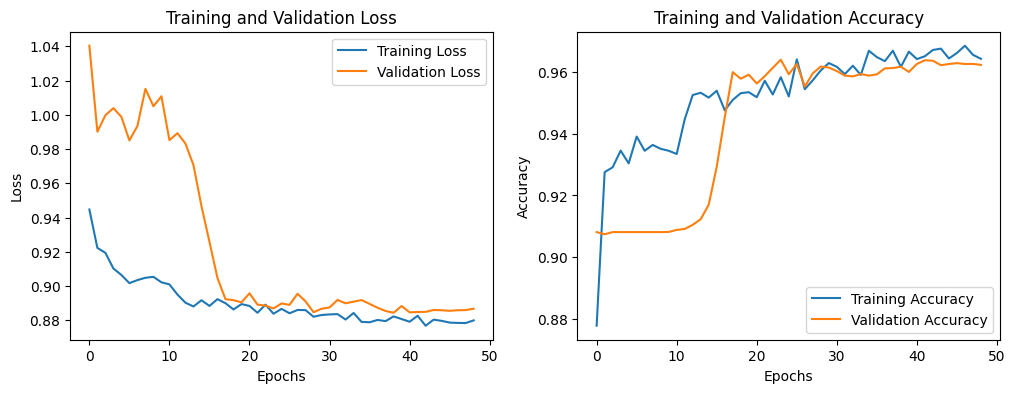

In [ ]:
 # Access the training history
deeplab_loss = deeplab_history.history['loss']
deeplab_val_loss = deeplab_history.history['val_loss']
deeplab_accuracy = deeplab_history.history['accuracy']
deeplab_val_accuracy = deeplab_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(deeplab_loss, label='Training Loss')
plt.plot(deeplab_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('lossepochs.png',dpi=300)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(deeplab_accuracy, label='Training Accuracy')
plt.plot(deeplab_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


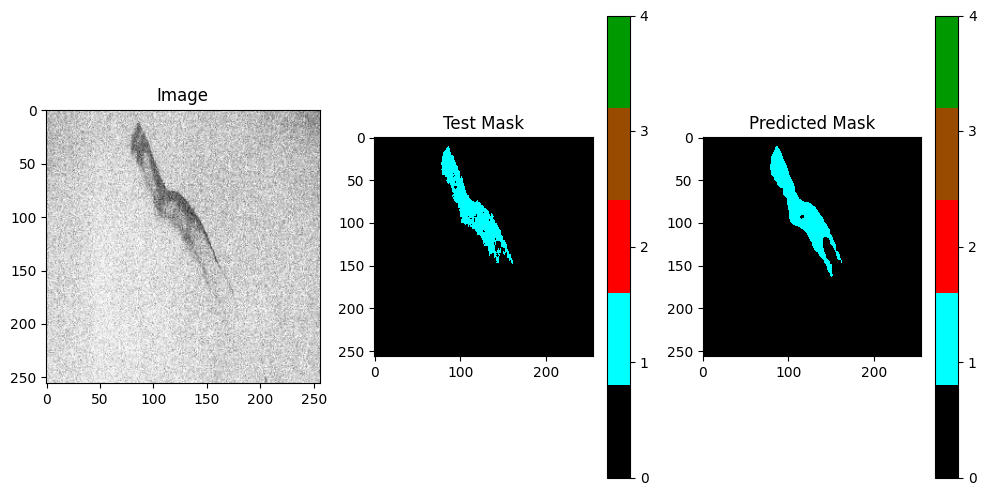

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


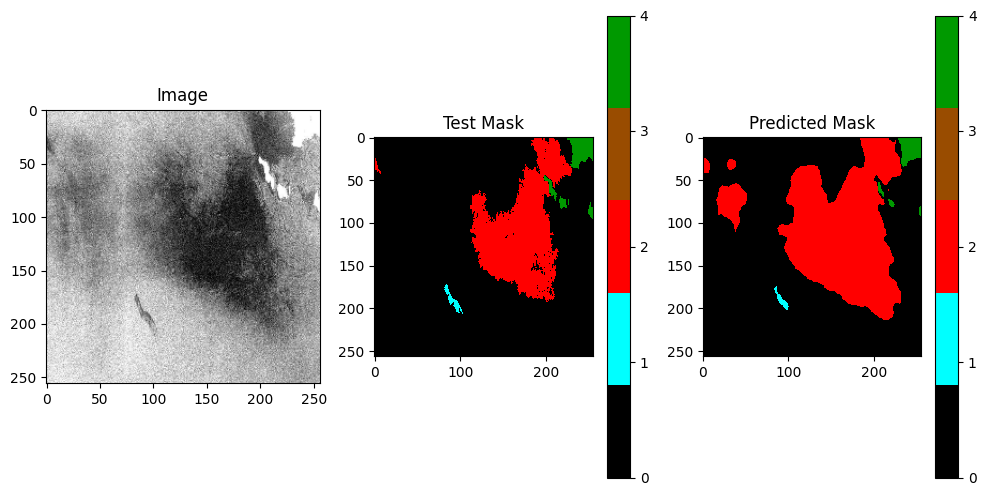

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


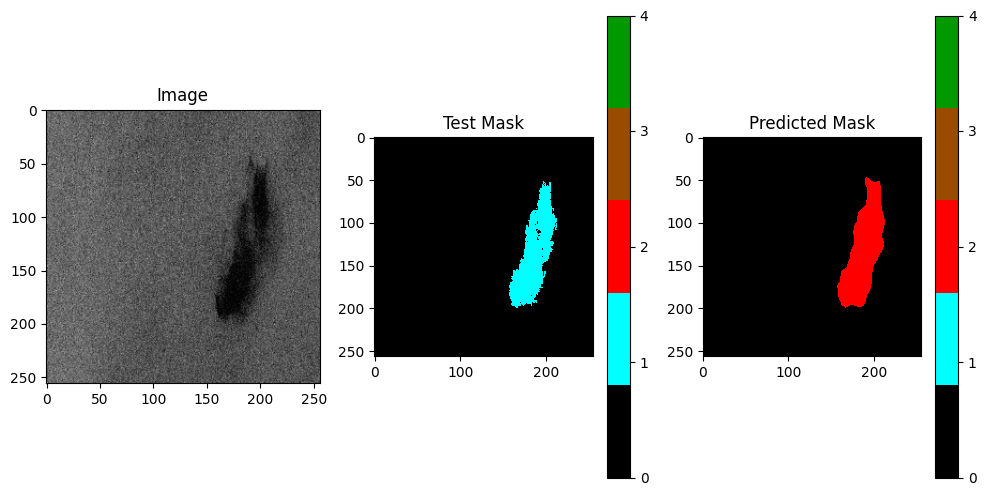

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


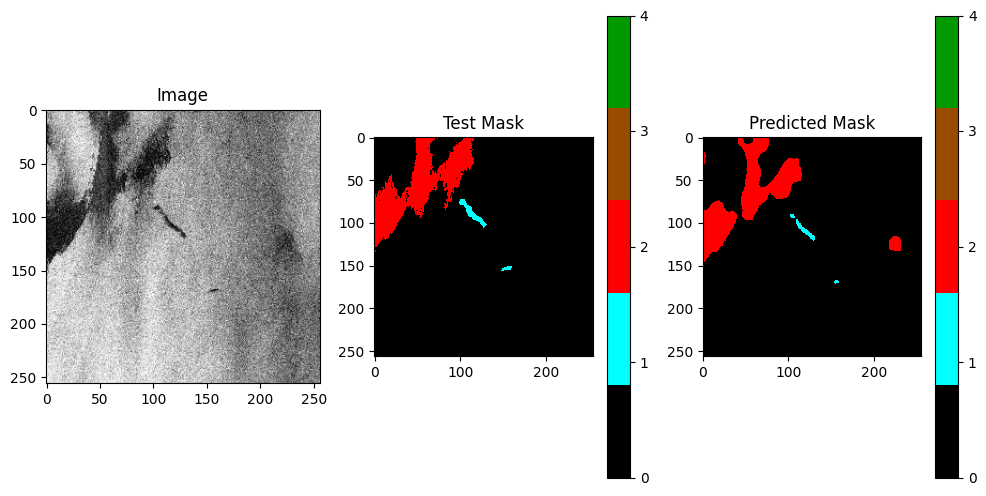

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


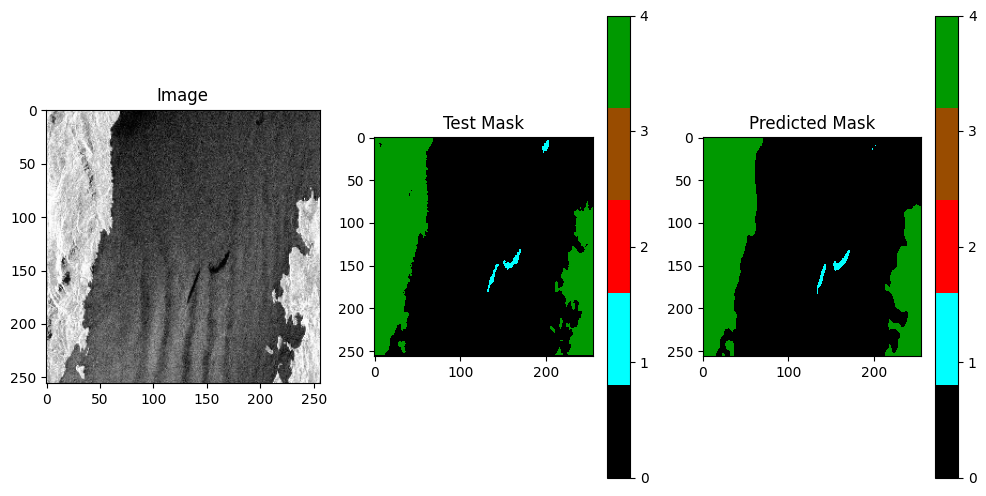

In [ ]:
# Specify the desired image indices
image_indices = [46, 60, 64, 68, 71]

num_images_to_plot = len(image_indices)  # Update num_images_to_plot

for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

    # Test Image
    plt.subplot(1, 3, 1)  # Subplot for the image
    test_image = test_images[image_indices[i]]  # Access image using image_indices
    plt.imshow(test_image)  # Display the image
    plt.title("Image")
    plt.savefig(f'image_{image_indices[i]}.png')  # Save the image with correct index

    # Test Mask
    plt.subplot(1, 3, 2)  # Subplot for the test mask
    test_mask = test_masks[image_indices[i]]  # Access mask using image_indices
    # Convert one-hot encoded mask to a single channel mask with class indices
    test_mask = np.argmax(test_mask, axis=-1) # get the class with highest probability
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Test Mask")
    plt.savefig(f'test_mask_{image_indices[i]}.png')  # Save the test mask with correct index


    # Predicted Mask
    plt.subplot(1, 3, 3)  # Subplot for the predicted mask
    prediction_deeplab = deeplab_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_deeplab = np.argmax(prediction_deeplab, axis=3)[0, :, :]
    plt.imshow(predicted_mask_deeplab.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Predicted Mask")
    plt.savefig(f'predicted_mask_{image_indices[i]}.png')  # Save the predicted mask with correct index

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

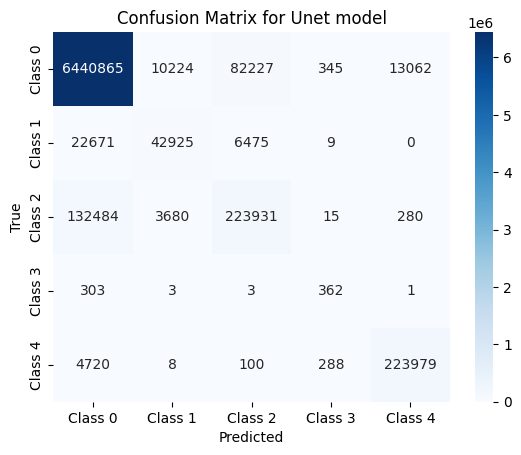

In [ ]:
# Assuming 'deeplab_model' is your trained model and 'test_images' are your test images

# Initialize an empty array to store predictions for all images
deeplab_all_predictions = []

# Iterate through all test images to get predictions for each image
for test_image in test_images:
    prediction_deeplab = deeplab_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_deeplab = np.argmax(prediction_deeplab, axis=3)[0, :, :]  # Get predicted mask for current image
    deeplab_all_predictions.append(predicted_mask_deeplab)  # Append predicted mask to the list


# Stack the predictions into a single array
deeplab_all_predictions = np.array(deeplab_all_predictions)

# Convert one-hot encoded test_masks to class indices
deeplab_true_labels = np.argmax(test_masks, axis=-1)  # Get the class with the highest probability for each pixel

# Reshape to match the predictions before flattening
deeplab_true_labels = deeplab_true_labels.reshape(-1)
deeplab_predicted_labels = deeplab_all_predictions.reshape(-1)  # Flatten the predicted labels

# Now you can generate the confusion matrix:
cm = confusion_matrix(deeplab_true_labels, deeplab_predicted_labels)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Unet model')
plt.show()

In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(deeplab_true_labels, deeplab_predicted_labels, average='weighted')
recall = recall_score(deeplab_true_labels, deeplab_predicted_labels, average='weighted')
f1 = f1_score(deeplab_true_labels, deeplab_predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9595
Recall: 0.9616
F1 Score: 0.9602
